<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/prakriti_MHCglobe_code_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Checking if my implementation that draws upon Eric's individual functions is correct

Current implementation: v1_troubleshoot_MHCGlobe_pipeline

1. Load all individual models
2. Train all of them on the entire database (just check that example data is not in here- I see there is overlap!!)
3. Predict each one on example data
4. Take the average
5. It should line up with what Eric has in the workflow

In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 710, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 710 (delta 92), reused 63 (delta 24), pack-reused 549
Receiving objects: 100% (710/710), 112.63 MiB | 32.95 MiB/s, done.
Resolving deltas: 100% (390/390), done.
Updating files: 100% (198/198), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240327T143106.569822726.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can in

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys
sys.path.append("/content/mhcglobe/src")

### Get data
Contains both BA+EL, human and non-human

In [3]:
import mhc_data
# 729,538/1,229,838
pMHC = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_data = pMHC.data
# pMHC_data.shape

#### Randomly pick 100 HLA-peptide peptide + Remove them from training data
These will be the test set, and is the same number of examples as in Eric's example df

In [32]:
# 678024
human_pMHC_data = pMHC_data[pMHC_data["allele"].str.contains("HLA")]
# 100 A LOT of non ='s for some reason...
human_pMHC_data_test = human_pMHC_data.sample(n=100, random_state=16)

# Seeing what happens if I only have ='s
# human_pMHC_data_test = human_pMHC_data.iloc[:100]

# 729438
pMHC_data_train = pMHC_data[~pMHC_data.index.isin(human_pMHC_data_test.index)]

In [33]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
644669,HLA-B*27:05,S3_Only,<,SA,100.0,RRFSRSDELTR,HLA-B,True,True
717608,HLA-B*51:01,S3_Only,<,SA,100.0,LPLPGSLL,HLA-B,True,True
115916,HLA-B*35:01,IEDB,=,BA,48.4,TLMAAILAY,HLA-B,True,True
723110,HLA-B*57:01,S3_Only,<,SA,100.0,KSGLNIAHF,HLA-B,True,True
264187,HLA-B*44:02,IEDB,<,SA,100.0,QEMFPQVPYHL,HLA-B,True,True
519974,HLA-A*02:07,S3_Only,<,SA,100.0,LLPSKAYTV,HLA-A,True,True
71415,HLA-B*08:01,IEDB,=,BA,370.0,EFINKFLEF,HLA-B,True,True
274126,HLA-C*05:01,IEDB,<,SA,100.0,FQDDNNLYL,HLA-C,True,True
35073,HLA-A*03:01,IEDB,=,BA,70100.0,NAMSFDGFIR,HLA-A,True,True
196907,HLA-A*29:02,IEDB,<,SA,100.0,YFFDNPRRY,HLA-A,True,True


#### Reset Indices to prevent any issues downstream

In [34]:
pMHC_data_train.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [35]:
pMHC_data_train = pMHC_data_train.reset_index(drop=True)
human_pMHC_data_test = human_pMHC_data_test.reset_index(drop=True)

In [36]:
pMHC_data_train.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*03:01,IEDB,=,BA,340.633333,EVMPVSMAK,HLA-A,True,True
1,HLA-A*11:01,IEDB,=,BA,17.140000,EVMPVSMAK,HLA-A,True,True
2,HLA-A*03:01,IEDB,=,BA,219.816667,KTFPPTEPK,HLA-A,True,True
3,HLA-A*11:01,IEDB,=,BA,222.213333,KTFPPTEPK,HLA-A,True,True
4,HLA-A*03:01,IEDB,=,BA,57.250000,RLYYDSMSY,HLA-A,True,True
5,HLA-A*11:01,IEDB,=,BA,237.025000,RLYYDSMSY,HLA-A,True,True
6,HLA-A*11:01,IEDB,=,BA,56.833333,AVLQSGFRK,HLA-A,True,True
7,HLA-A*03:01,IEDB,=,BA,2069.000000,KCYGVSATK,HLA-A,True,True
8,HLA-A*11:01,IEDB,=,BA,8375.750000,KCYGVSATK,HLA-A,True,True
9,HLA-A*03:01,IEDB,=,BA,188.033333,QLFKPLTKK,HLA-A,True,True


In [37]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-B*27:05,S3_Only,<,SA,100.0,RRFSRSDELTR,HLA-B,True,True
1,HLA-B*51:01,S3_Only,<,SA,100.0,LPLPGSLL,HLA-B,True,True
2,HLA-B*35:01,IEDB,=,BA,48.4,TLMAAILAY,HLA-B,True,True
3,HLA-B*57:01,S3_Only,<,SA,100.0,KSGLNIAHF,HLA-B,True,True
4,HLA-B*44:02,IEDB,<,SA,100.0,QEMFPQVPYHL,HLA-B,True,True
5,HLA-A*02:07,S3_Only,<,SA,100.0,LLPSKAYTV,HLA-A,True,True
6,HLA-B*08:01,IEDB,=,BA,370.0,EFINKFLEF,HLA-B,True,True
7,HLA-C*05:01,IEDB,<,SA,100.0,FQDDNNLYL,HLA-C,True,True
8,HLA-A*03:01,IEDB,=,BA,70100.0,NAMSFDGFIR,HLA-A,True,True
9,HLA-A*29:02,IEDB,<,SA,100.0,YFFDNPRRY,HLA-A,True,True


#### Get 4 relevant columns

In [39]:
pMHC_data_train = pMHC_data_train[["allele", "peptide", "measurement_inequality", "measurement_value"]]

In [40]:
pMHC_data_train.head(10)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-A*03:01,EVMPVSMAK,=,340.633333
1,HLA-A*11:01,EVMPVSMAK,=,17.140000
2,HLA-A*03:01,KTFPPTEPK,=,219.816667
3,HLA-A*11:01,KTFPPTEPK,=,222.213333
4,HLA-A*03:01,RLYYDSMSY,=,57.250000
5,HLA-A*11:01,RLYYDSMSY,=,237.025000
6,HLA-A*11:01,AVLQSGFRK,=,56.833333
7,HLA-A*03:01,KCYGVSATK,=,2069.000000
8,HLA-A*11:01,KCYGVSATK,=,8375.750000
9,HLA-A*03:01,QLFKPLTKK,=,188.033333


### Make X_tr, Y_tr, X_es, Y_es for training

In [41]:
import mhcglobe
# loads the init model
ensemble = mhcglobe.ensemble(train_type="init")
# DOES depend on init/full!
setup_data_training = ensemble.setup_data_training(pMHC_data_train)
# I don't think this is deterministic
X_tr, Y_tr, X_es, Y_es = setup_data_training

### Load base tensorflow models individually and train
Idea is that these trained models should be equivalent to full models that are loaded into the ensemble, and used for final predictions.

In [42]:
import train_functions as trainf
model_dir = "/content/mhcglobe/model/mhcglobe/init/"

model_1 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model14_fold13_ONE_HOT_init/")
model_2 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model37_fold15_ONE_HOT_init/")
model_3 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model79_fold9_ONE_HOT_init/")

In [43]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_1
new_model_1 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

In [44]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_2
new_model_2 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

In [45]:
new_model_path, verbose = "/content/mhcglobe/outputs", 0
init_model = model_3
new_model_3 = trainf.train_mhcglobe_model(init_model, X_tr, Y_tr, X_es, Y_es, new_model_path, verbose)

### Predict individually on example data

In [46]:
# prediction 1
import sequence_functions as seqf
import binding_affinity as ba

to_predict = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]
X = seqf.get_XY(to_predict, encode_type="ONE_HOT", get_Y=False)


In [47]:
def get_prediction_df(new_model, X, to_predict):
  mhcglobe_scores = new_model.predict(X)

  # Get them
  mhcglobe_scores = mhcglobe_scores.flatten()
  mhcglobe_affinities = list(map(ba.to_ic50, mhcglobe_scores))

  prediction_dict = {"mhcglobe_affinities": mhcglobe_affinities, "mhcglobe_scores": mhcglobe_scores}
  prediction_df = pd.DataFrame(prediction_dict)

  # Munge to_predict so I can correctly concatenate the columns
  munged_to_predict = to_predict
  munged_to_predict.index = prediction_df.index

  # Present the data nicely!
  prediction_df_all = pd.concat([munged_to_predict, prediction_df], axis=1)
  return(prediction_df_all)


In [49]:
prediction_df_1 = get_prediction_df(new_model_1, X, to_predict)
prediction_df_1.head(10)

4/4 [==============================] - 0s 4ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,93.754480,0.580335
1,HLA-B*51:01,LPLPGSLL,<,100.0,162.128999,0.529714
2,HLA-B*35:01,TLMAAILAY,=,48.4,264.807631,0.484370
3,HLA-B*57:01,KSGLNIAHF,<,100.0,116.119178,0.560562
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,138.041707,0.544579
5,HLA-A*02:07,LLPSKAYTV,<,100.0,62.841475,0.617311
6,HLA-B*08:01,EFINKFLEF,=,370.0,323.736701,0.465800
7,HLA-C*05:01,FQDDNNLYL,<,100.0,80.778534,0.594103
8,HLA-A*03:01,NAMSFDGFIR,=,70100.0,650.152634,0.401355
9,HLA-A*29:02,YFFDNPRRY,<,100.0,91.998535,0.582083


In [50]:
prediction_df_2 = get_prediction_df(new_model_2, X, to_predict)
prediction_df_2.head(10)

4/4 [==============================] - 0s 3ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,101.398648,0.573091
1,HLA-B*51:01,LPLPGSLL,<,100.0,101.822164,0.572706
2,HLA-B*35:01,TLMAAILAY,=,48.4,124.363205,0.554223
3,HLA-B*57:01,KSGLNIAHF,<,100.0,97.239102,0.576962
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,96.871750,0.577312
5,HLA-A*02:07,LLPSKAYTV,<,100.0,95.356315,0.578770
6,HLA-B*08:01,EFINKFLEF,=,370.0,172.708466,0.523871
7,HLA-C*05:01,FQDDNNLYL,<,100.0,98.842577,0.575451
8,HLA-A*03:01,NAMSFDGFIR,=,70100.0,7884.485283,0.170718
9,HLA-A*29:02,YFFDNPRRY,<,100.0,93.626808,0.580461


In [51]:
prediction_df_3 = get_prediction_df(new_model_3, X, to_predict)
prediction_df_3.head(10)

4/4 [==============================] - 0s 3ms/step


,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinities,mhcglobe_scores
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,101.688687,0.572827
1,HLA-B*51:01,LPLPGSLL,<,100.0,90.271809,0.583834
2,HLA-B*35:01,TLMAAILAY,=,48.4,122.931625,0.555293
3,HLA-B*57:01,KSGLNIAHF,<,100.0,101.998893,0.572546
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,93.947253,0.580145
5,HLA-A*02:07,LLPSKAYTV,<,100.0,98.153300,0.576098
6,HLA-B*08:01,EFINKFLEF,=,370.0,148.536361,0.537807
7,HLA-C*05:01,FQDDNNLYL,<,100.0,87.591513,0.586620
8,HLA-A*03:01,NAMSFDGFIR,=,70100.0,14906.039475,0.111856
9,HLA-A*29:02,YFFDNPRRY,<,100.0,75.430103,0.600435


### Get average results

In [52]:
# Average mhcglobe_scores
mhcglobe_affinities_df1 = prediction_df_1['mhcglobe_affinities']
mhcglobe_affinities_df2 = prediction_df_2['mhcglobe_affinities']
mhcglobe_affinities_df3 = prediction_df_3['mhcglobe_affinities']

In [67]:
mhcglobe_affinities_df1.head(5)

0     93.754480
1    162.128999
2    264.807631
3    116.119178
4    138.041707
Name: mhcglobe_affinities, dtype: float64

In [68]:
mhcglobe_affinities_df2.head(5)

0    101.398648
1    101.822164
2    124.363205
3     97.239102
4     96.871750
Name: mhcglobe_affinities, dtype: float64

In [69]:
mhcglobe_affinities_df3.head(5)

0    101.688687
1     90.271809
2    122.931625
3    101.998893
4     93.947253
Name: mhcglobe_affinities, dtype: float64

In [71]:
all_affinities = pd.concat([mhcglobe_affinities_df1, mhcglobe_affinities_df2, mhcglobe_affinities_df3], axis=1)
all_affinities.head(5)

,mhcglobe_affinities,mhcglobe_affinities,mhcglobe_affinities
0,93.754480,101.398648,101.688687
1,162.128999,101.822164,90.271809
2,264.807631,124.363205,122.931625
3,116.119178,97.239102,101.998893
4,138.041707,96.871750,93.947253


In [70]:
average_mhcglobe_affinities = all_affinities.mean(axis=1)
average_mhcglobe_affinities.head(5)

0     98.947272
1    118.074324
2    170.700820
3    105.119058
4    109.620237
dtype: float64

### Compare with true values

In [76]:
human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]].head(5)

,allele,peptide,measurement_inequality,measurement_value
0,HLA-B*27:05,RRFSRSDELTR,<,100.0
1,HLA-B*51:01,LPLPGSLL,<,100.0
2,HLA-B*35:01,TLMAAILAY,=,48.4
3,HLA-B*57:01,KSGLNIAHF,<,100.0
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0


In [83]:
prediction_df_comparison = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]
prediction_df_comparison["predicted_mhcglobe_affinities"] = average_mhcglobe_affinities
prediction_df_comparison

<ipython-input-83-793e7b2bb1ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df_comparison["predicted_mhcglobe_affinities"] = average_mhcglobe_affinities


,allele,peptide,measurement_inequality,measurement_value,predicted_mhcglobe_affinities
0,HLA-B*27:05,RRFSRSDELTR,<,100.0,98.947272
1,HLA-B*51:01,LPLPGSLL,<,100.0,118.074324
2,HLA-B*35:01,TLMAAILAY,=,48.4,170.700820
3,HLA-B*57:01,KSGLNIAHF,<,100.0,105.119058
4,HLA-B*44:02,QEMFPQVPYHL,<,100.0,109.620237
...,...,...,...,...,...
95,HLA-B*40:02,WEKEEQEIL,<,100.0,97.578552
96,HLA-A*68:02,QGVNDNEEGFFSAR,<,100.0,135.807454
97,HLA-B*27:05,ISRNQKLLQ,<,100.0,116.133170
98,HLA-A*02:06,ETQSGALEV,=,9615.0,1510.635964


### Plot + Get r^2

In [79]:
import matplotlib.pyplot as plt
def make_scatter_plot(df, x_col, y_col):
  plt.scatter(df[x_col], df[y_col])
  plt.xlabel(x_col)
  plt.ylabel(y_col)
  plt.title("Scatter Plot")
  plt.show()

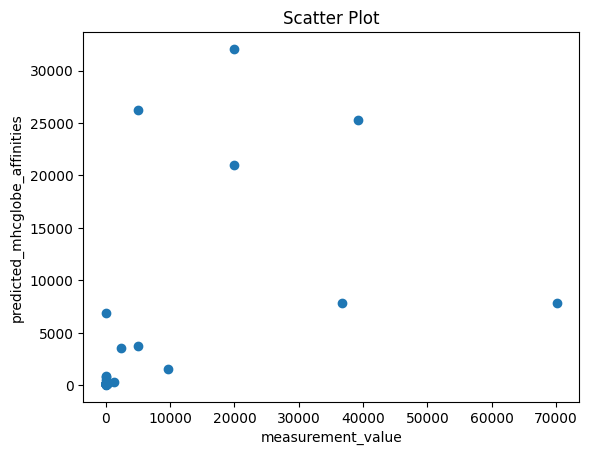

In [80]:
make_scatter_plot(prediction_df_comparison, "measurement_value", "predicted_mhcglobe_affinities")

In [81]:
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error

def get_r_squared_mse(df, x_col, y_col):
  slope, intercept, r_value, p_value, std_err = linregress(df[x_col], df[y_col])
  mse = mean_squared_error(df[x_col], df[y_col])
  return(r_value**2, mse)

In [82]:
my_predictions_r, my_predictions_mse = get_r_squared_mse(prediction_df_comparison, "measurement_value", "predicted_mhcglobe_affinities")
print("R-squared:", my_predictions_r)
print("MSE:", my_predictions_mse)

R-squared: 0.32643101790012236
MSE: 56223663.03905643


## How did Eric do?
Amazingly!!!

Note: Good, this is reproducible!

In [56]:
# Load MHCGlobe class object containing the fully trained model.
mhcglobe_model = mhcglobe.ensemble(train_type='full')

# Load binding data as CSV. Required columns are `allele` and `peptide`.
example_binding_data = '/content/mhcglobe/example/example_binding_data.csv'
prediction_cols = ['allele', 'peptide']
# pMHC_data = pd.read_csv(example_binding_data, usecols=prediction_cols)
example_data = pd.read_csv(example_binding_data)

# Predict peptide-MHC binding with MHCGlobe
eric_predictions = mhcglobe_model.predict_on_dataframe(example_data)

In [57]:
eric_predictions

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinity,mhcglobe_score
0,HLA-B*15:01,AQMWSLMYF,=,0.330000,64.439289,0.614990
1,HLA-A*33:01,DIDILQTNSR,=,314.000000,396.717038,0.447011
2,HLA-B*38:01,QPKKAAAAL,>,20000.000000,20009.976327,0.084641
3,HLA-A*31:01,FLALGFFLR,=,43.000000,117.473925,0.559490
4,HLA-B*07:02,RPQKRPSCI,=,7.819348,104.042288,0.570712
...,...,...,...,...,...,...
95,HLA-A*30:01,KAFNHASVK,=,34.700000,118.069387,0.559023
96,HLA-A*02:01,WMMAMKYPI,=,54.000000,61.744092,0.618939
97,HLA-A*02:03,FLMGFNRDV,=,1.000000,30.050617,0.685494
98,HLA-A*02:01,LLSTTEWQV,=,67.000000,91.183992,0.582905


### Plot + Get r^2

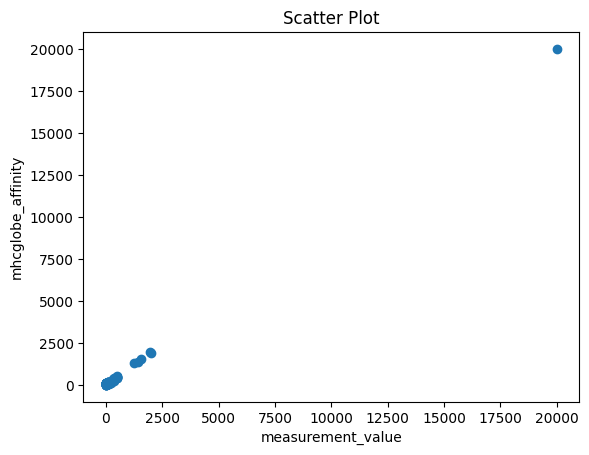

In [58]:
make_scatter_plot(eric_predictions, "measurement_value", "mhcglobe_affinity")

In [59]:
eric_predictions_r, eric_predictions_mse = get_r_squared_mse(eric_predictions, "measurement_value", "mhcglobe_affinity")
print("R-squared:", eric_predictions_r)
print("MSE:", eric_predictions_mse)

R-squared: 0.9994910366115101
MSE: 4199.057414035893


### Take a look at BA

In [60]:
eric_predictions_subset = eric_predictions[eric_predictions['measurement_inequality'] == '=']
eric_predictions_subset

,allele,peptide,measurement_inequality,measurement_value,mhcglobe_affinity,mhcglobe_score
0,HLA-B*15:01,AQMWSLMYF,=,0.330000,64.439289,0.614990
1,HLA-A*33:01,DIDILQTNSR,=,314.000000,396.717038,0.447011
3,HLA-A*31:01,FLALGFFLR,=,43.000000,117.473925,0.559490
4,HLA-B*07:02,RPQKRPSCI,=,7.819348,104.042288,0.570712
5,HLA-A*31:01,RIGGVLIFR,=,11.000000,81.121732,0.593712
...,...,...,...,...,...,...
95,HLA-A*30:01,KAFNHASVK,=,34.700000,118.069387,0.559023
96,HLA-A*02:01,WMMAMKYPI,=,54.000000,61.744092,0.618939
97,HLA-A*02:03,FLMGFNRDV,=,1.000000,30.050617,0.685494
98,HLA-A*02:01,LLSTTEWQV,=,67.000000,91.183992,0.582905


In [61]:
eric_predictions_subset_r, eric_predictions_subset_mse = get_r_squared_mse(eric_predictions_subset, "measurement_value", "mhcglobe_affinity")
print("R-squared:", eric_predictions_subset_r)
print("MSE:", eric_predictions_subset_mse)

R-squared: 0.9891813856229511
MSE: 4515.2827426143895
